In [1]:
# Ensure the project root is in PATH.
import sys
sys.path.append("../")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing, Trade

import numpy as np
import pandas as pd
import sys
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
market_data_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_-1.csv"), sep=";")
market_data_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_0.csv"), sep=";")
market_data_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_1.csv"), sep=";")

trades_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_-1.csv"), sep=";")
trades_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_0.csv"), sep=";")
trades_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_1.csv"), sep=";")



# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

market_data_round_2_all3days = concatenate_historical_data([market_data_round_2_day_neg1, market_data_round_2_day_0, market_data_round_2_day_1])
trades_round_2_all3days = concatenate_historical_data([trades_round_2_day_neg1, trades_round_2_day_0, trades_round_2_day_1])


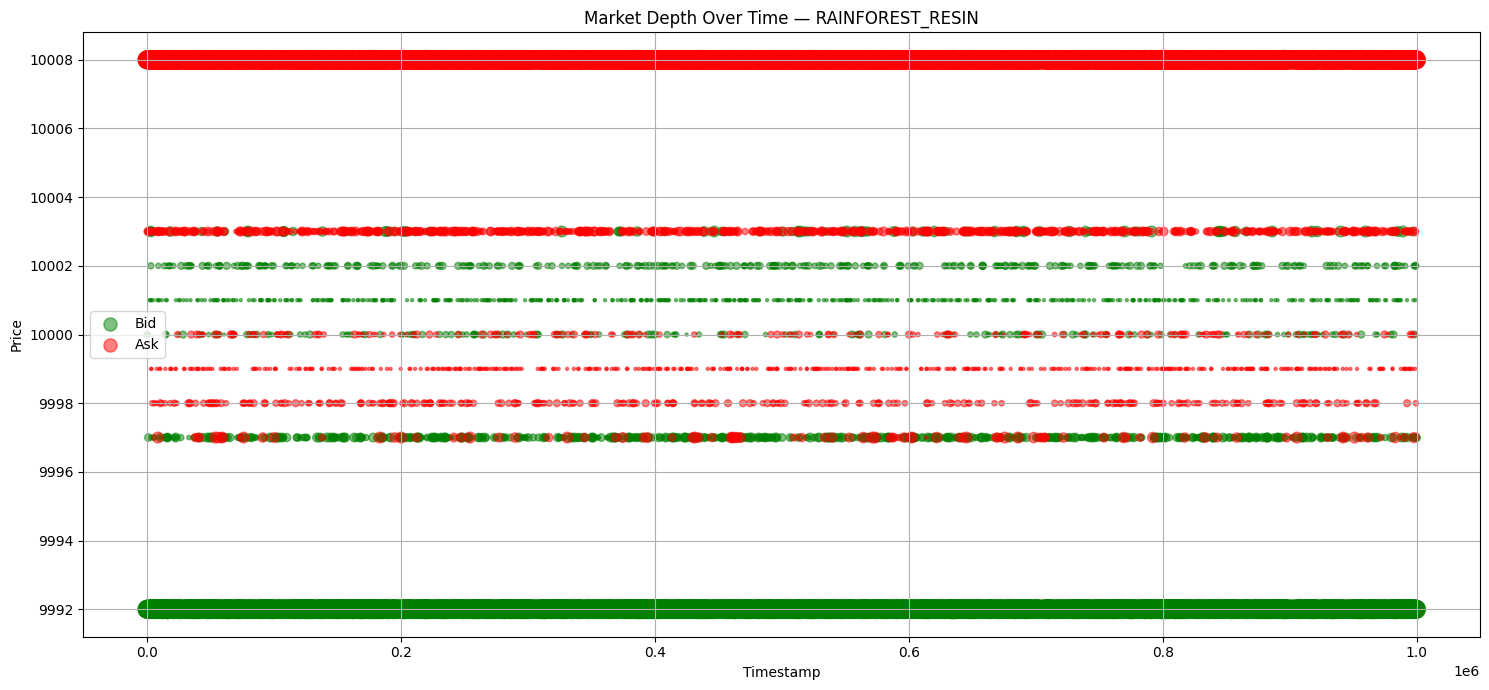

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Use the new data
market_data = market_data_round_2_day_0
market_data = market_data[market_data['product'] == "RAINFOREST_RESIN"].copy()

# Compute mid_price if not already done
if "mid_price" not in market_data.columns:
    market_data["mid_price"] = market_data[["bid_price_1", "ask_price_1"]].mean(axis=1)

plt.figure(figsize=(15, 7))

# Plot bid prices
for i in range(1, 4):
    mask = ~market_data[f"bid_price_{i}"].isna()
    plt.scatter(
        market_data.loc[mask, "timestamp"],
        market_data.loc[mask, f"bid_price_{i}"],
        s=market_data.loc[mask, f"bid_volume_{i}"] * 5,
        color="green",
        alpha=0.5,
        label="Bid" if i == 1 else "",
    )

# Plot ask prices
for i in range(1, 4):
    mask = ~market_data[f"ask_price_{i}"].isna()
    plt.scatter(
        market_data.loc[mask, "timestamp"],
        market_data.loc[mask, f"ask_price_{i}"],
        s=market_data.loc[mask, f"ask_volume_{i}"] * 5,
        color="red",
        alpha=0.5,
        label="Ask" if i == 1 else "",
    )
 

plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Market Depth Over Time — RAINFOREST_RESIN")

plt.ticklabel_format(style="plain", axis="y")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%d"))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


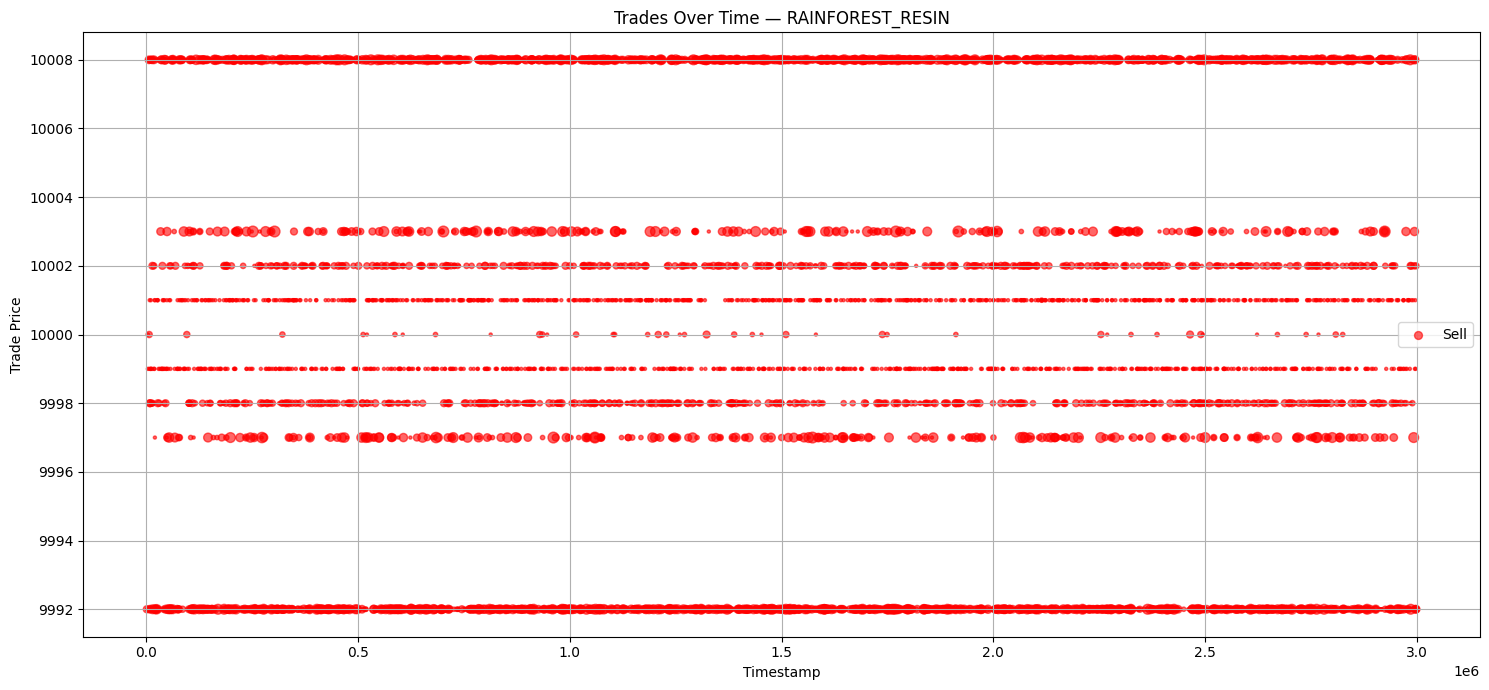

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Filter trade history
trade_history = trades_round_2_all3days
trade_history = trade_history[trade_history['symbol'] == 'RAINFOREST_RESIN'].copy()

plt.figure(figsize=(15, 7))

 
plt.scatter(
    trade_history['timestamp'],
    trade_history['price'],
    s=trade_history["quantity"] * 5,
    color="red",
    alpha=0.6,
    label="Sell"
)

plt.xlabel("Timestamp")
plt.ylabel("Trade Price")
plt.title("Trades Over Time — RAINFOREST_RESIN")

plt.ticklabel_format(style="plain", axis="y")
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter("%d"))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Gridsearch

In [2]:
class ResinTrader2:
    def __init__(self):
        # config
        self.position_limit = {"RAINFOREST_RESIN": 50}
        self.symbol = "RAINFOREST_RESIN"

        self.sk1 = 0.00
        self.sk2 = 0.00
        self.sk3 = 0.00
        self.sk4 = 0.00
        self.sk5 = 0.00
        self.sk6 = 0.00
        self.sk7 = 0.00

        self.bk1 = 0.00
        self.bk2 = 0.00
        self.bk3 = 0.00
        self.bk4 = 0.00
        self.bk5 = 0.00
        self.bk6 = 0.00
        self.bk7 = 0.00
        
        # runtime
        self.max_position = 0
        self.min_position = 0
        pass

    # takes +ev orders from the orderbook.
    def take_best_orders(self, state: TradingState, orderbook: OrderDepth) -> list[Order]:
        orders: list[Order] = []

        max_buy_amount = self.position_limit[self.symbol] - self.max_position
        max_sell_amount = abs(-self.position_limit[self.symbol] - self.min_position)

        if len(orderbook.buy_orders) != 0:
            best_bid_price = max(orderbook.buy_orders.keys())
            best_bid_volume = orderbook.buy_orders[best_bid_price]

            if best_bid_price > 10000:
                fill_quantity = min(max_sell_amount, best_bid_volume)

                if fill_quantity > 0:
                    orders.append(Order(self.symbol, best_bid_price, -fill_quantity))
                    del orderbook.buy_orders[best_bid_price]

        if len(orderbook.sell_orders) != 0:
            best_ask_price = min(orderbook.sell_orders.keys())
            best_ask_volume = abs(orderbook.sell_orders[best_ask_price])

            if best_ask_price < 10000:
                fill_quantity = min(max_buy_amount, best_ask_volume)

                if fill_quantity > 0:
                    orders.append(Order(self.symbol, best_ask_price, fill_quantity))
                    del orderbook.sell_orders[best_ask_price]

        return orders

    # puts in some quoting orders
    def add_mm_orders(self, state: TradingState) -> list[Order]:
        orders: list[Order] = []

        max_buy_amount = self.position_limit[self.symbol] - self.max_position
        max_sell_amount = abs(-self.position_limit[self.symbol] - self.min_position)

       
        portion = max_sell_amount / 7
        sq1 = self.sk1 * portion
        sq2 = self.sk2 * portion
        sq3 = self.sk3 * portion
        sq4 = self.sk4 * portion
        sq5 = self.sk5 * portion
        sq6 = self.sk6 * portion
        sq7 = self.sk7 * (max_sell_amount - 6 * int(portion))

        portion = max_buy_amount / 7
        bq1 = self.bk1 * portion
        bq2 = self.bk2 * portion
        bq3 = self.bk3 * portion
        bq4 = self.bk4 * portion
        bq5 = self.bk5 * portion
        bq6 = self.bk6 * portion
        bq7 = self.bk7 * (max_buy_amount - 6 * int(portion))

        orders.append(Order(self.symbol, 10001, -int(sq1)))
        orders.append(Order(self.symbol, 10002, -int(sq2)))
        orders.append(Order(self.symbol, 10003, -int(sq3)))
        orders.append(Order(self.symbol, 10004, -int(sq4)))
        orders.append(Order(self.symbol, 10005, -int(sq5)))
        orders.append(Order(self.symbol, 10006, -int(sq6)))
        orders.append(Order(self.symbol, 10007, -int(sq7)))

        orders.append(Order(self.symbol, 9999, int(bq1)))
        orders.append(Order(self.symbol, 9998, int(bq2)))
        orders.append(Order(self.symbol, 9997, int(bq3)))
        orders.append(Order(self.symbol, 9996, int(bq4)))
        orders.append(Order(self.symbol, 9995, int(bq5)))
        orders.append(Order(self.symbol, 9994, int(bq6)))
        orders.append(Order(self.symbol, 9993, int(bq7)))

        return orders

    def init_runtime_variables(self, state: TradingState):
        self.max_position = state.position[self.symbol] if self.symbol in state.position else 0
        self.min_position = state.position[self.symbol] if self.symbol in state.position else 0

    def run(self, state: TradingState):
        self.init_runtime_variables(state)

        result = {}
        for product in state.order_depths:
            orders: list[Order] = []

            if product == "RAINFOREST_RESIN":
                took = self.take_best_orders(state, state.order_depths[product])

                while len(took) != 0:
                    orders = orders + took

                    for order in took:
                        if order.quantity > 0:
                            self.max_position += order.quantity
                        elif order.quantity < 0:
                            self.min_position -= abs(order.quantity)

                    took = self.take_best_orders(state, state.order_depths[product])

                took = self.add_mm_orders(state)
                orders = orders + took

                for order in took:
                    if order.quantity > 0:
                        self.max_position += order.quantity
                    elif order.quantity < 0:
                        self.min_position -= abs(order.quantity)

            result[product] = orders
        traderData = "SAMPLE"  # String value holding Trader state data required. It will be delivered as TradingState.traderData on next execution.

        conversions = 1
        return result, conversions, traderData

In [3]:
# 1. Define the listings.
listings = {
    "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    "CROISSANTS": Listing(symbol="CROISSANTS", product="CROISSANTS", denomination="SEASHELLS"),
    "JAMS": Listing(symbol="JAM", product="JAM", denomination="SEASHELLS"),
    "DJEMBES": Listing(symbol="DJEMBES", product="DJEMBES", denomination="SEASHELLS"),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
    "PICNIC_BASKET1": Listing(symbol="PICNIC_BASKET1", product="PICNIC_BASKET1", denomination="SEASHELLS"),
    "PICNIC_BASKET2": Listing(symbol="PICNIC_BASKET2", product="PICNIC_BASKET2", denomination="SEASHELLS"),
}

# 2. Define the position limits.
position_limit = {
    "KELP": 50,
    "RAINFOREST_RESIN": 50,
    "SQUID_INK": 50,
    "CROISSANTS": 250,
    "JAMS": 350,
    "DJEMBES": 60,
    "PICNIC_BASKET1": 60,
    "PICNIC_BASKET2": 100,
}


# 4. Market data and trade history files.
market_data_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_-1.csv"), sep=";")
market_data_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_0.csv"), sep=";")
market_data_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "prices_round_2_day_1.csv"), sep=";")

trades_round_2_day_neg1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_-1.csv"), sep=";")
trades_round_2_day_0 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_0.csv"), sep=";")
trades_round_2_day_1 = pd.read_csv(os.path.join("..", "data", "round2", "trades_round_2_day_1.csv"), sep=";")
 
# 5. Instantiate trader object
# Define the function to be run in each process
from joblib import Parallel, delayed
from itertools import product
from tqdm import tqdm
import numpy as np

# Define your grid resolution and range for each skx (can be finer or coarser)
n_points = 4#9
sk_vals = np.linspace(0.0, 1.0, n_points)

# Generate all possible (sk1,...,sk7) combinations where the sum <= 1
param_grid = [
    weights for weights in product(sk_vals, repeat=7)
    if sum(weights) <= 1.0
]

print(f"Grid size: {len(param_grid)} combinations")

# Function to be parallelized
def run_backtest_independent(sk_weights):
    trader = ResinTrader2()

    # Set both skx and bkx to the same values
    for i in range(1, 8):
        setattr(trader, f"sk{i}", sk_weights[i - 1])
        setattr(trader, f"bk{i}", sk_weights[i - 1])

    # Run backtester
    bt = Backtester(
        trader,
        listings,
        position_limit, 
        market_data_round_2_day_neg1,
        trades_round_2_day_neg1,
        output_log_filename=None
    )
    bt.run()

    pnl = bt.pnl()['spreadcrossing']['RAINFOREST_RESIN']
    return (tuple(sk_weights), pnl)



# Run the grid search
results = Parallel(n_jobs=-1)(
    delayed(run_backtest_independent)(weights)
    for weights in tqdm(param_grid, desc="Grid Search")
)

# Sort and display top results
scores = dict(results)
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print("\nTop results:")
for weights, pnl in sorted_scores[:20]:
    sk_str = ", ".join([f"sk{i+1}={weights[i]:.2f}" for i in range(7)])
    print(f"{sk_str} => P&L = {pnl:.2f}")


Grid size: 120 combinations


Grid Search: 100%|██████████| 120/120 [03:54<00:00,  1.96s/it]



Top results:
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=0.00, sk6=0.00, sk7=1.00 => P&L = 35327.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=0.00, sk6=0.00, sk7=0.67 => P&L = 32866.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=0.00, sk6=1.00, sk7=0.00 => P&L = 29948.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=0.00, sk6=0.67, sk7=0.33 => P&L = 29115.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=1.00, sk6=0.00, sk7=0.00 => P&L = 26654.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=0.00, sk6=0.67, sk7=0.00 => P&L = 26541.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=0.67, sk6=0.00, sk7=0.33 => P&L = 26420.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=0.67, sk6=0.33, sk7=0.00 => P&L = 25709.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=0.00, sk6=0.00, sk7=0.33 => P&L = 24851.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.00, sk5=0.67, sk6=0.00, sk7=0.00 => P&L = 23821.00
sk1=0.00, sk2=0.00, sk3=0.00, sk4=0.67, sk5=0.00, sk6=0.00, sk7=0.33 => P&L = 23725.00
sk1=0.00, sk2=0.00, sk3=0.00,